In [17]:
# To add a new cell, type '# %%'
# To add a new markdown cell, type '# %% [markdown]'

In [1]:
# To add a new cell, type '# %%'
# To add a new markdown cell, type '# %% [markdown]'
import time
# ### Cab-Driver Agent

In [2]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import tensorflow as tf
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver
 
# #### Defining Time Matrix

In [3]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

# #### Tracking the state-action pairs for checking convergence
#

In [4]:

#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
 
# ### Agent Class
# 
# If you are using this framework, you need to fill the following to complete the following code block:
# 1. State and Action Size
# 2. Hyperparameters
# 3. Create a neural-network model in function 'build_model()'
# 4. Define epsilon-greedy strategy in function 'get_action()'
# 5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
# 6. Complete the 'train_model()' function with following logic:
#    - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
#       - Initialise your input and output batch for training the model
#       - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
#       - Get Q(s', a) values from the last trained model
#       - Update the input batch as your encoded state and output batch as your Q-values
#       - Then fit your DQN model using the updated input and output batch.

In [5]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size
        self.track_state = np.array(env.state_encoder([0,0,0]))
        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate =   0.01
        self.epsilon = 1
        self.epsilon_max = 1
        #self.epsilon_decay = -0.0005
        self.epsilon_decay = -0.0009

        self.epsilon_min = 0.00001
        #self.states_tracked = []
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets  
        
        # hidden layers
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))

        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state,action_space):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment       
         if np.random.rand() <= self.epsilon:
            # explore: choose a random action from all possible actions
            # in case of cartpole this will randomly choose an action between 0 and 1
            #return random.randrange(self.action_size)
            return random.choice(action_space)
         else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
                        #state = np.array(env.state_encoder(state)).reshape(1, 36)
                        state = env.state_encoder(state)  
                        q_value = self.model.predict(state)
                        action = env.action_space[np.argmax(q_value)]
                        return action
        
        
        
        


    def append_sample(self, state, action, reward, next_state,terminal):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state,terminal))
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            # initialise two matrices - update_input and update_output
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            #actions, rewards, done = [], [], []
            list_action = env.action_space
            actions_mini, reward_mini,done = [], [],[]
            
            for i in range(self.batch_size):
                state, action, reward, next_state,terminal = mini_batch[i]
                update_input[i] = env.state_encoder(state)  
                actions_mini.append(action)
                reward_mini.append(reward)
                update_output[i] = env.state_encoder(next_state)
                done.append(terminal)
                
                # Write your code from here
                # 1. Predict the target from earlier model
            #print("output_input",tf.shape(update_input))
            target = self.model.predict(update_input)
                
            #print("output_out",tf.shape(update_output))    
                # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)
                
                #3. Update your 'update_output' and 'update_input' batch
                
            for i in range(self.batch_size):
                    hi = actions_mini[i]
                    index= list_action.index(hi)
                    if done[i]:
                       
                        target[i][index] = reward_mini[i]
                    else: # non-terminal state
                        target[i][index] = reward_mini[i] + self.discount_factor * np.max(target_qval[i])
                
        # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

    def save(self, name):
        self.model.save(name)
        with open(name, 'wb') as file:  
            pickle.dump(self.model, file,pickle.HIGHEST_PROTOCOL)
        
    def store_q_values(self):
        """ We are keeping track of q value for state [0,0,0] and action (0,2)"""
        q_value = self.model.predict(self.track_state)
        #print(q_value[0][2])
        states_tracked.append(q_value[0][2])

In [6]:
Episodes =  10000
states_tracked = []
# Defining hyperparameters
m = 5 # number of cities, ranges from 1 ..... m
t = 24 # number of hours, ranges from 0 .... t-1
d = 7  # number of days, ranges from 0 ... d-1
C = 5 # Per hour fuel and other costs
R = 9 # per hour revenue from a passenger
rewards_tracked_episode=[]
average_rewards=[]
# ### DQN block
#rewards_count=0

In [7]:
start_time = time.time()
for episode in range(Episodes):
 
    rewards_count=0
    # Write code here
    # Call the environment
    env = CabDriver()
    # Call all the initialised variables of the environment
    action_space, state_space, state = env.reset()
    state_size = m+t+d
    action_size = len(action_space)
    terminal_state= False
    #Call the DQN agent
    agent = DQNAgent(action_size=action_size, state_size=state_size)
    #if episode!=0:
    #agent.epsilon = 1 * np.exp(agent.epsilon_decay * episode)
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon = agent.epsilon_min + (agent.epsilon_max - agent.epsilon_min) * np.exp(agent.epsilon_decay*episode)
    #print("epsilon",agent.epsilon)
    while not terminal_state:
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        greedy_action = agent.get_action(state,action_space)
       
        # 2. Evaluate your reward and next state
        next_state,rewards = env.next_state_func(state,greedy_action,Time_matrix)
        terminal_state = env.Terminalstate
        # 3. Append the experience to the memory
        agent.append_sample(state, greedy_action, rewards, next_state,terminal_state)
        rewards_count = rewards_count+rewards
        # 4. Train the model by calling function agent.train_model
        agent.train_model()
        # 5. Keep a track of rewards, Q-values, loss

        state=next_state
    rewards_tracked_episode.append(rewards_count)
    average_rewards.append(sum(rewards_tracked_episode)/len(rewards_tracked_episode))
    if (episode%1==0):
        agent.store_q_values()
        print("maximum of rewards",max(rewards_tracked_episode),"episodes",episode,"minimum of rewards",min(rewards_tracked_episode),"average of rewards",(sum(rewards_tracked_episode)/len(rewards_tracked_episode)),"epsilon",round(agent.epsilon,3))
    
    if (episode % 1000 == 0):
        agent.save(name="model.pkl")
elapsed_time = time.time() - start_time
print('Total time taken ',elapsed_time)

0.0
maximum of rewards 2991.0 episodes 9827 minimum of rewards -802.0 average of rewards 368.6141636141636 epsilon 0.0
maximum of rewards 2991.0 episodes 9828 minimum of rewards -802.0 average of rewards 368.5771696001628 epsilon 0.0
maximum of rewards 2991.0 episodes 9829 minimum of rewards -802.0 average of rewards 368.5324516785351 epsilon 0.0
maximum of rewards 2991.0 episodes 9830 minimum of rewards -802.0 average of rewards 368.51825856983015 epsilon 0.0
maximum of rewards 2991.0 episodes 9831 minimum of rewards -802.0 average of rewards 368.63720504475185 epsilon 0.0
maximum of rewards 2991.0 episodes 9832 minimum of rewards -802.0 average of rewards 368.66602257703653 epsilon 0.0
maximum of rewards 2991.0 episodes 9833 minimum of rewards -802.0 average of rewards 368.65588773642463 epsilon 0.0
maximum of rewards 2991.0 episodes 9834 minimum of rewards -802.0 average of rewards 368.6180986273513 epsilon 0.0
maximum of rewards 2991.0 episodes 9835 minimum of rewards -802.0 averag

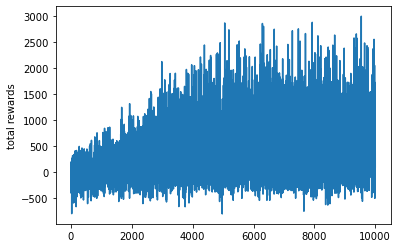

In [8]:
# Check Convergence by tracking total rewards per episode vs episode number
plt.plot(list(range(len(rewards_tracked_episode))), rewards_tracked_episode)
plt.ylabel("total rewards")
plt.show()

In [9]:

# ### Tracking Convergence

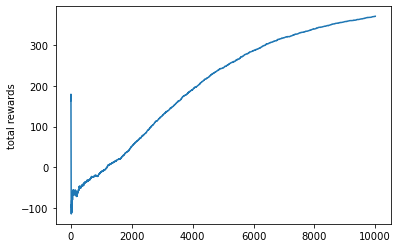

In [10]:
# Check Convergence by tracking total rewards per episode vs episode number
plt.plot(list(range(len(average_rewards))), average_rewards)
plt.ylabel("total rewards")
plt.show()

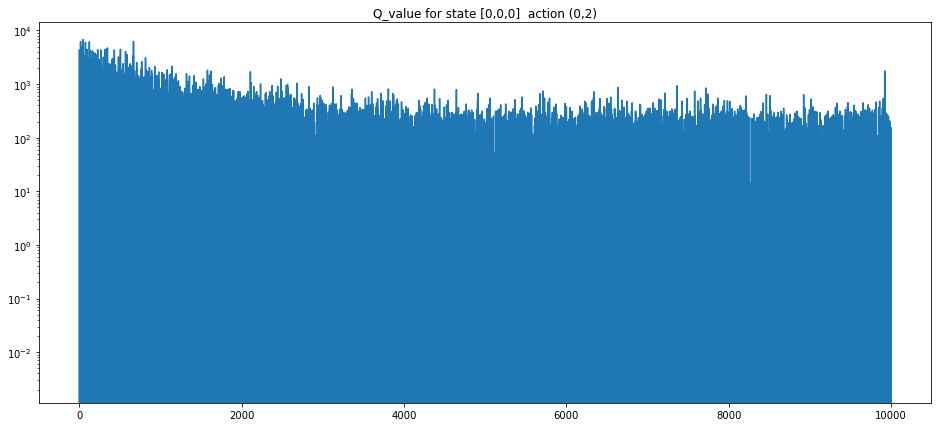

In [11]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [0,0,0]  action (0,2)')
xaxis = np.asarray(range(0, len(states_tracked)))
plt.semilogy(xaxis,np.asarray(states_tracked))
plt.show()

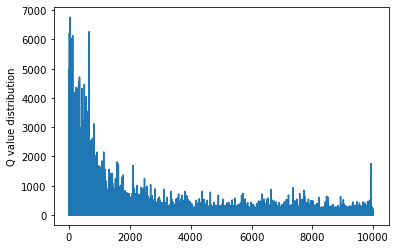

In [12]:
plt.plot(list(range(len(states_tracked))), states_tracked)
plt.ylabel("Q value distribution")
plt.show()

In [13]:


# #### Epsilon-decay sample function
 
# <div class="alert alert-block alert-info">
# Try building a similar epsilon-decay function for your model.
# </div>

In [14]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

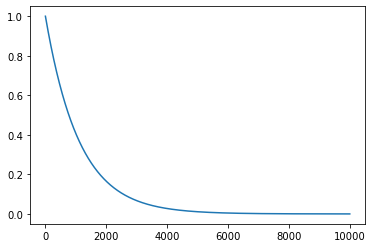

In [15]:
plt.plot(time, epsilon)
plt.show()